In [1]:
#Libraries
import pandas as pd                  # Data Manipulation
import numpy as np                   # Matrices support
import matplotlib.pyplot as plt      # Plotting
import seaborn as sns                # Statistical Visualization
from matplotlib import cm
from scipy import stats
from numpy.polynomial.polynomial import polyfit
from random import randint
import math

# Data Read

In [57]:
data = pd.read_excel('201713_ECOAS_Anonimizado.xlsx')

In [42]:
data.head(5)

,Ejercicio,Crn,ID_Prof,Rectoría del Campus,Campus,División,Departamento,Tesis en título,Número de Grupo,Categoría Laboral,...,Journal Q1/Q2,Journal Q3/Q4,Total Docs,Book Norm.,Book Series Norm.,Conference Proceeding Norm.,Journal Q1/Q2 Norm.,Journal Q3/Q4 Norm.,Total Docs. Norm.,mxn_sn
0,201713,300,1453688,Región Sur,Campus Toluca,"69 - Arq, Arte y Diseño",DII - Diseño Industrial,0.0,1,PLA - Planta,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1
1,201713,317,701591,Región Sur,Campus Toluca,"69 - Arq, Arte y Diseño",AR - Arquitectura,0.0,1,-,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1
2,201713,320,1089805,Región Sur,Campus Toluca,"69 - Arq, Arte y Diseño",AR - Arquitectura,0.0,2,-,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1
3,201713,321,925702,Región Sur,Campus Toluca,"69 - Arq, Arte y Diseño",DII - Diseño Industrial,0.0,1,PLA - Planta,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1
4,201713,322,925702,Región Sur,Campus Toluca,"69 - Arq, Arte y Diseño",DII - Diseño Industrial,0.0,2,PLA - Planta,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,1


Base de datos de 15781 registros

Plan:
- Hacer una variable de clasificación (bueno/malo) para cada profesor. Debemos de generar un criterio de que es considerado bueno, en base a las 3 respuestas de la ECOA.
- Encontrar que variables son las que impactan más a las respuestas de la ECOA.
- Una vez que conozco las variables que predicen mejor el performance. Aplicar clustering para ver si los individuos poseen características similares, respecto a lo deseado.

# Data Validation

In [94]:
#La variable 'Crn UV' únicamente tiene el valor "No aplica", por lo que descartamos esta columna
data['Crn UV'].unique
data = data.drop(['Crn UV'],axis=1)

In [95]:
#La variable 'Grupo Virtual' tiene el valor "NO", por lo que descartamos esta columna 
print(data[['Grupo Virtual','ID_Prof']].groupby(['Grupo Virtual'],as_index=False).count())
data = data.drop(['Grupo Virtual'],axis=1)

  Grupo Virtual  ID_Prof
0            NO    15780


In [97]:
# Remplaza los nan de la columna de "Tesis en título" con 0s 
data['Tesis en título'] = data['Tesis en título'].fillna(0)
tesis = data[['Tesis en título','ID_Prof']].groupby(['Tesis en título'],as_index=False).count()
tesis['porcentaje'] = tesis['ID_Prof']/len(data)*100
tesis.head()

,Tesis en título,ID_Prof,porcentaje
0,0.0,15236,96.54648
1,1.0,545,3.45352


In [165]:
#Crea la variable sni_sn
data.rename(columns = {'Nivel SNI 2019':'SNI'}, inplace = True)
sni = data[['Nivel SNI 2019','ID_Prof']].groupby(['Nivel SNI 2019'],as_index=False).count()
sni['porcentaje'] = sni['ID_Prof']/len(data)*100
sni.head()

#El 90% de los profesores no son investigadores. Creo una variable 1 (SNI) 0 (no SNI) llamada sni_sn
a = [];
num = data['SNI'].isnull()*1
for index,value in enumerate(num):
    if value == 0:
        a.append('SNI')
    else:
        a.append('NO SNI')
data['sni_sn'] = a              

In [102]:
#Replace nan values of multiple columns to 0s
nan_list = ['Book','Book Series','Conference Proceeding','Journal Q1/Q2','Journal Q3/Q4','Total Docs','Book Norm.',
            'Book Series Norm.','Conference Proceeding Norm.','Journal Q1/Q2 Norm.','Journal Q3/Q4 Norm.',
            'Total Docs. Norm.']

for index,value in enumerate(nan_list):
    data[value] = data[value].fillna(0)

In [106]:
#Promedio de la calificación de las 3 preguntas
data['calif'] = (data['05 Prom'] + data['05 Prom'] + data['05 Prom'])/3

In [166]:
#Crea la variable profefional si(1) o no()
a = [];
for index,value in enumerate(data['Nivel materia']):
    if value == 'Profesional':
        a.append('Profesional')
    else:
        a.append('Posgrado')
data['prof_sn'] = a

# Data Exploration

In [5]:
#Cuenta la cantidad de profesores por nacionalidad y agrega una columna del porcentaje del total
prof_nacionalidad =  data[['Nacionalidad','ID_Prof']].groupby(['Nacionalidad'],as_index=False).count().sort_values(['ID_Prof'],ascending=False)
prof_nacionalidad['porcentaje'] = prof_nacionalidad['ID_Prof']/len(data)*100
prof_nacionalidad.head()

,Nacionalidad,ID_Prof,porcentaje
34,Mexicana,14866,94.201888
21,Estadounidense,122,0.773082
20,Española,88,0.557633
30,Italiana,74,0.468918
11,Colombiana,68,0.430898


In [172]:
#Debido a que hay 56 nacionalidad diferentes de profesores, creamos una variable llamada mxn_sn (mexicano si o no) que es
#1 es mexicano y 0 cuando es extranjero
a = [];
for index,value in enumerate(data['Nacionalidad']):
    if value == 'Mexicana':
        a.append('Mexicano');
    else:
        a.append('Extranjero');
data['mxn_sn'] = a        

In [7]:
#Cantidad de hombres y mujeres profesores
prof_genero = data[['Género','ID_Prof']].groupby(['Género'],as_index=False).count()
prof_genero['porcentaje'] = prof_genero['ID_Prof']/len(data)*100
prof_genero

,Género,ID_Prof,porcentaje
0,Femenino,6243,39.560231
1,Masculino,9538,60.439769


In [123]:
#Profesores Investigadores de Campus Monterrey
c1 = data['Campus']=='Campus Monterrey';
c2 = data['División'] == 'IN - Esc. Ingeniería y Ciencias'
c3 = data['sni_sn'] == 1
c31 = data['sni_sn'] != 1

temp = data[c1&c3];
print('Calificación Promedio:',temp['calif'].mean())
print('Porcentaje de Profesores: ', len(temp)/len(data[c1&c2]))

Calificación Promedio: 9.338054187192121
Porcentaje de Profesores:  0.558282208588957


In [122]:
#Profesores No Investigadores de Campus Monterrey
#Profesores Investigadores de Campus Monterrey
c1 = data['Campus']=='Campus Monterrey';
c2 = data['División'] == 'IN - Esc. Ingeniería y Ciencias'
c3 = data['sni_sn'] == 1
c31 = data['sni_sn'] != 1

temp = data[c1&c31];
print('Calificación Promedio:',temp['calif'].mean())
print('Porcentaje de Profesores: ', len(temp)/len(data[c1&c2]))

Calificación Promedio: 9.008627113786194
Porcentaje de Profesores:  2.3803680981595092


In [119]:
#Profesores Investigadores de Campus Monterrey de Ingenieria y Ciencias
temp = data[c1&c2&c3]

print('Calificación Promedio:',temp['calif'].mean())
print('Porcentaje de Profesores: ', len(temp)/len(data[c1&c2]))

,Departamento,Tesis en título,Número de Grupo,Categoría Laboral,Puesto (Escolar),Puesto (RH),Nacionalidad,Género,Edad al semestre,Años de Antigüedad,...,Journal Q3/Q4,Total Docs,Book Norm.,Book Series Norm.,Conference Proceeding Norm.,Journal Q1/Q2 Norm.,Journal Q3/Q4 Norm.,Total Docs. Norm.,sni_sn,calif
5891,MECM - Mec y Materiales Avanzad,1.0,9,PLA - Planta,Profesor planta,Profesor,Mexicana,Masculino,NaN,8.750000,...,4.0,47,8.4,0.0,0.0,9.9,3.4,4.4,1,10.0
5892,MECM - Mec y Materiales Avanzad,1.0,3,PLA - Planta,Profesor planta multicampus,Profesor Investigador,Mexicana,Masculino,NaN,18.350000,...,1.0,24,0.0,0.0,0.9,5.3,0.8,1.4,1,10.0
5898,MR - Mecatrónica,0.0,4,PLA - Planta,Profesor planta,Profesor,Mexicana,Masculino,38.90486,8.263889,...,0.0,4,4.2,0.0,1.9,0.2,0.0,1.3,1,9.5


Calificación Promedio: 9.450352941176474
Porcentaje de Profesores:  0.294478527607362


In [120]:
#Profesores No Investigadores de Campus Monterrey de Ingenieria y Ciencias
temp = data[c1&c2&c3].drop(['Campus','División','Crn','ID_Prof','Rectoría del Campus','Ejercicio',],axis=1)

print('Calificación Promedio:',temp['calif'].mean())
print('Porcentaje de Profesores: ', len(temp)/len(data[c1&c2]))

Calificación Promedio: 8.993223620522746
Porcentaje de Profesores:  0.7055214723926381


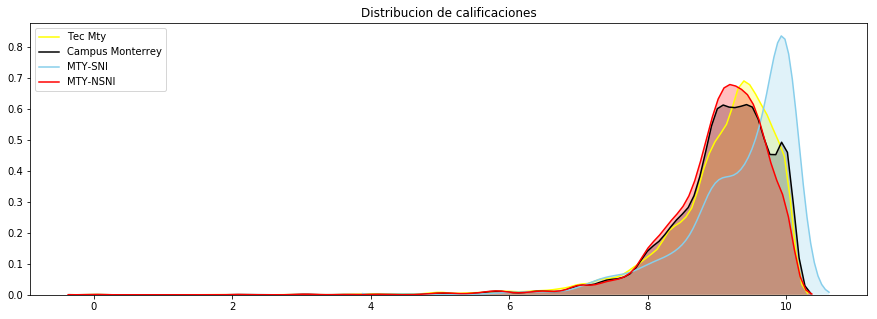

In [145]:
#Distribucion de logaritmica de ventas segun el tamaño de cliente
#plt.clf()
fig, ax = plt.subplots(figsize=(15,5))

ax.grid(False)
sns.kdeplot( data['calif'].dropna(), color="yellow", label="Tec Mty",shade = True)
sns.kdeplot( data[c1]['calif'].dropna(), color="black", label="Campus Monterrey",shade=True)
sns.kdeplot( data[c1&c3]['calif'].dropna(), color="skyblue", label="MTY-SNI",shade=True)
sns.kdeplot( data[c1&c31]['calif'].dropna(), color="red", label="MTY-NSNI",shade=True)

#sns.distplot( data[c1]['calif'], color="green", label="PEQUEÑO")
#sns.distplot( data[c1]['calif'], color="orange", label="MICRO")
plt.title('Distribucion de calificaciones')
plt.legend()
plt.show()
#display(fig)

## Clase de Posgrado vs Profesional 

Profesional : 9.021163661109233
Posgrado : 9.451841085271314


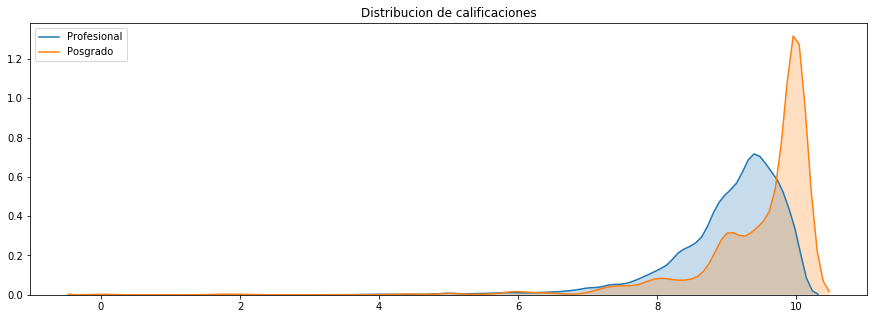

In [169]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(False)

for index,value in enumerate(data['prof_sn'].unique()):
    sns.kdeplot( data[data['prof_sn']==value]['calif'].dropna(), label=value,shade = True)
    print(value,':', data[data['prof_sn']==value]['calif'].dropna().mean())

plt.title('Distribucion de calificaciones')
plt.legend()
plt.show()

## Hombre o Mujer

Femenino : 9.054748513578694
Masculino : 9.045938552188607


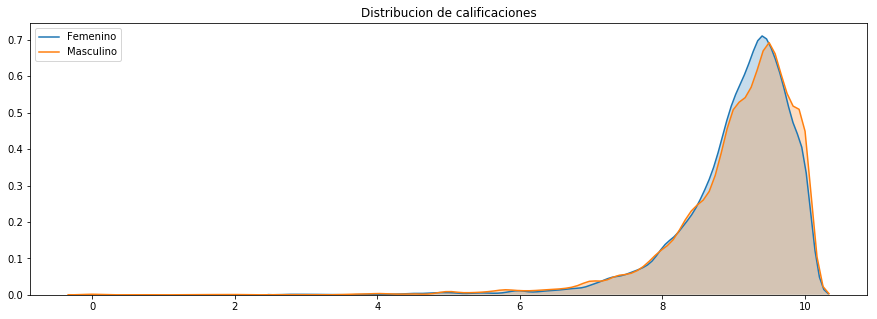

In [175]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(False)

for index,value in enumerate(data['Género'].unique()):
    sns.kdeplot( data[data['Género']==value]['calif'].dropna(), label=value,shade = True)
    print(value,':', data[data['Género']==value]['calif'].dropna().mean())

plt.title('Distribucion de calificaciones')
plt.legend()
plt.show()

## Mexicano o Extranjero


Mexicano : 9.049021460386019
Extranjero : 9.055995599559955


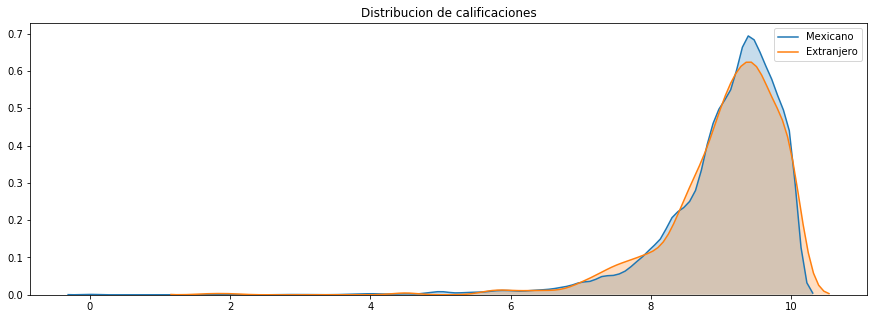

In [173]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(False)

for index,value in enumerate(data['mxn_sn'].unique()):
    sns.kdeplot( data[data['mxn_sn']==value]['calif'].dropna(), label=value,shade = True)
    print(value,':', data[data['mxn_sn']==value]['calif'].dropna().mean())

plt.title('Distribucion de calificaciones')
plt.legend()
plt.show()

## SNI vs Profesores

NO SNI : 9.019594737212433
SNI : 9.32945838837516


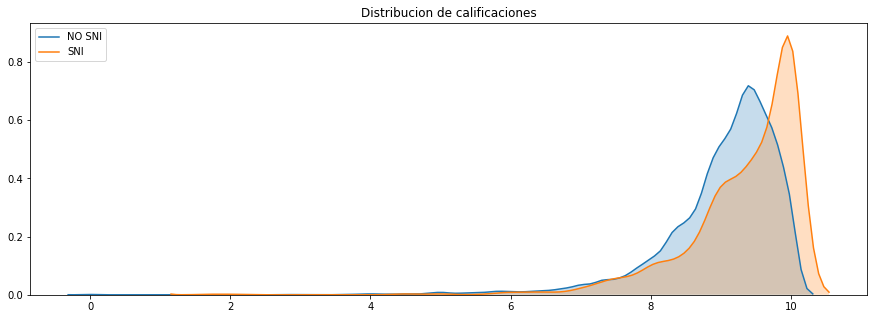

In [168]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(False)

for index,value in enumerate(data['sni_sn'].unique()):
    sns.kdeplot( data[data['sni_sn']==value]['calif'].dropna(), label=value,shade = True)
    print(value,':', data[data['sni_sn']==value]['calif'].dropna().mean())

plt.title('Distribucion de calificaciones')
plt.legend()
plt.show()

## Nivel estudio profesor
Hay tres niveles de estudio: Profesional, Maestría y Doctorado. Considerando todos los campus.

Doctorado : 9.097815490160714
Maestría : 9.02206466250711
Profesional : 9.03047690014901
nan : nan


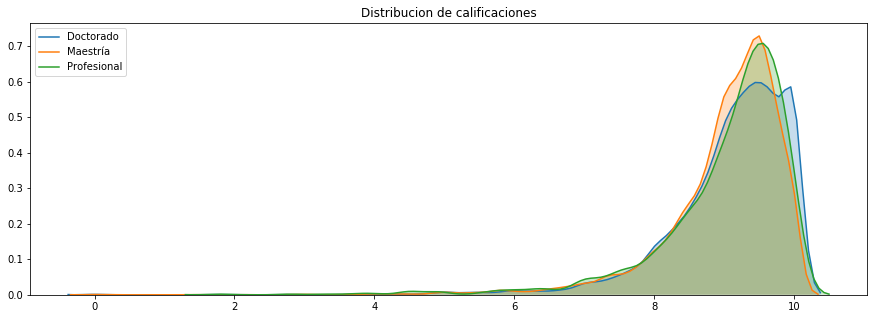

In [157]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(False)

for index,value in enumerate(data['Grado Máximo Prof'].unique()):
    sns.kdeplot( data[data['Grado Máximo Prof']==value]['calif'].dropna(), label=value,shade = True)
    print(value,':', data[data['Grado Máximo Prof']==value]['calif'].dropna().mean())

plt.title('Distribucion de calificaciones')
plt.legend()
plt.show()

In [153]:
#